# Data Imputation for Expedia Hotel Dataset



In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import time

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting styles
sns.set_style("whitegrid")
sns.set_palette('viridis')

## Loading the Dataset


In [28]:
# Load the dataset (sample for faster processing)
print("Loading dataset sample...")
df_sample = pd.read_csv("../data/training_set_VU_DM.csv", nrows=100000)
print(f"Loaded {len(df_sample):,} rows with {len(df_sample.columns)} columns")

# Display first few rows
df_sample.head()

Loading dataset sample...
Loaded 100,000 rows with 54 columns


,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.50,1,2.83,0.04,4.95,27,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.00,0.00,NaN,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.00,1,2.20,0.01,5.03,26,170.74,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.50,1,2.20,0.02,4.92,21,179.80,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.00,0.00,NaN,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.00,1,2.83,0.01,4.39,34,602.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,-1.00,0.00,5.00,-1.00,0.00,5.00,NaN,NaN,NaN,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,0.00,5.00,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.50,1,2.64,0.12,4.93,4,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.00,0.00,NaN,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0,NaN,0


## Analysis of Missing Values



In [29]:
# Calculate missing value percentages for each column
missing_data = pd.DataFrame({
    'Missing Values': df_sample.isnull().sum(),
    'Percentage': (df_sample.isnull().sum() / len(df_sample) * 100).round(2)
})

missing_data = missing_data.sort_values('Percentage', ascending=False)

# Display columns with missing values
missing_data[missing_data['Missing Values'] > 0]

,Missing Values,Percentage
comp1_rate_percent_diff,98098,98.10
comp6_rate_percent_diff,97983,97.98
comp1_rate,97668,97.67
comp1_inv,97489,97.49
comp4_rate_percent_diff,97451,97.45
gross_bookings_usd,97209,97.21
comp7_rate_percent_diff,97012,97.01
comp6_rate,94885,94.88
visitor_hist_starrating,94561,94.56
visitor_hist_adr_usd,94542,94.54


In [34]:
# Identify columns with less than 50% missing values
imputable_cols = missing_data[(missing_data['Percentage'] > 0) & (missing_data['Percentage'] < 50)].index.tolist()

print(f"Columns with less than 50% missing values (to be imputed): {len(imputable_cols)}")
imputable_cols

Columns with less than 50% missing values (to be imputed): 3


['orig_destination_distance', 'prop_location_score2', 'prop_review_score']

## Categorizing Features for Imputation

Different imputation strategies are appropriate for different types of features. Let's categorize our imputable features.

In [35]:
# Categorize features
numeric_features = df_sample[imputable_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_sample[imputable_cols].select_dtypes(include=['object', 'bool']).columns.tolist()

print(f"Numeric features with missing values: {len(numeric_features)}")
print(numeric_features)

print(f"\nCategorical features with missing values: {len(categorical_features)}")
print(categorical_features)

Numeric features with missing values: 3
['orig_destination_distance', 'prop_location_score2', 'prop_review_score']

Categorical features with missing values: 0
[]


## Understanding the Data Context



orig_destination_distance:
Missing: 32,092 (32.09%)
Non-Missing Statistics:
count   67908.00
mean     1310.84
std      2025.86
min         0.01
25%       145.44
50%       382.49
75%      1504.08
max     11631.95
Name: orig_destination_distance, dtype: float64


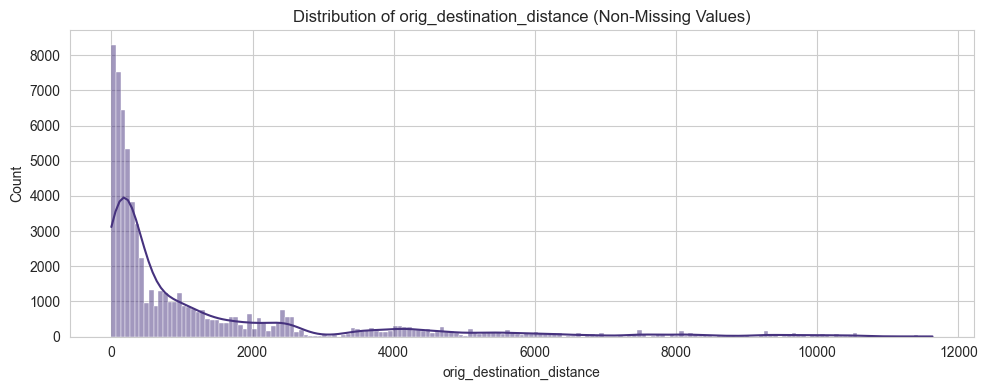


prop_location_score2:
Missing: 21,728 (21.73%)
Non-Missing Statistics:
count   78272.00
mean        0.13
std         0.16
min         0.00
25%         0.02
50%         0.07
75%         0.18
max         1.00
Name: prop_location_score2, dtype: float64


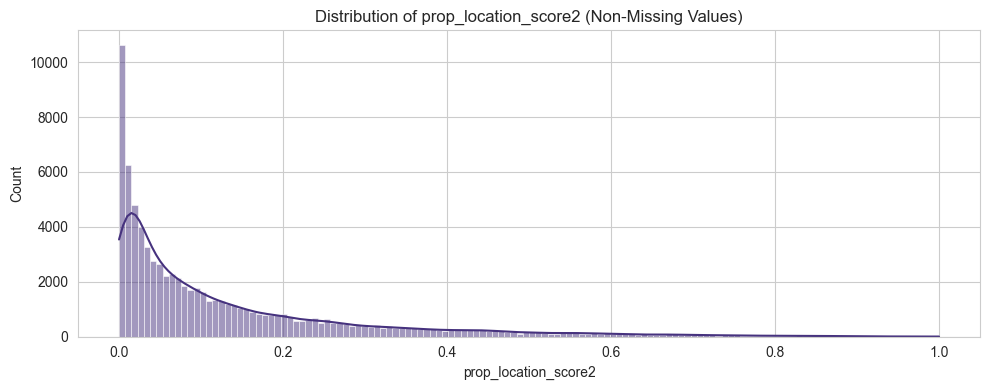


prop_review_score:
Missing: 141 (0.14%)
Non-Missing Statistics:
count   99859.00
mean        3.81
std         1.02
min         0.00
25%         3.50
50%         4.00
75%         4.50
max         5.00
Name: prop_review_score, dtype: float64


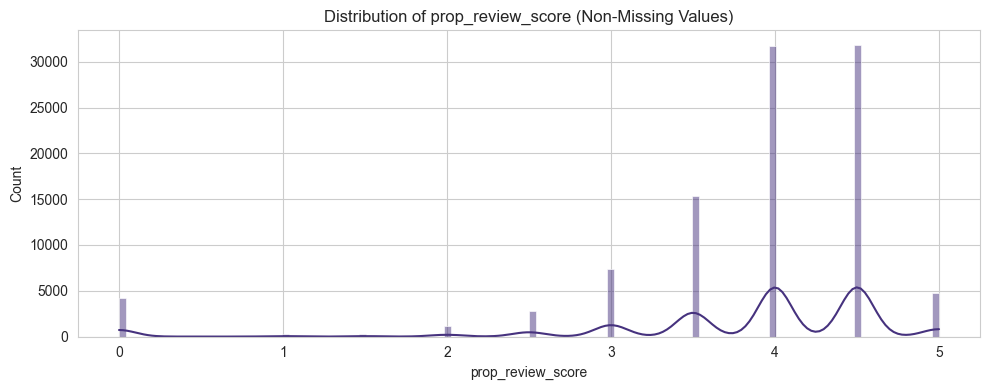

In [36]:
# Analyze key features with missing values
for col in imputable_cols:
    if col in numeric_features:
        print(f"\n{col}:")
        print(f"Missing: {df_sample[col].isnull().sum():,} ({df_sample[col].isnull().sum() / len(df_sample) * 100:.2f}%)")
        print(f"Non-Missing Statistics:")
        print(df_sample[col].describe())
        
        # Visualize distribution of non-missing values
        plt.figure(figsize=(10, 4))
        sns.histplot(df_sample[col].dropna(), kde=True)
        plt.title(f'Distribution of {col} (Non-Missing Values)')
        plt.tight_layout()
        plt.show()

## Basic Imputation Functions


In [37]:
def mean_imputation(df, columns):
    """Impute missing values with mean for each column"""
    imputer = SimpleImputer(strategy='mean')
    df_imputed = df.copy()
    df_imputed[columns] = imputer.fit_transform(df[columns])
    return df_imputed

def median_imputation(df, columns):
    """Impute missing values with median for each column"""
    imputer = SimpleImputer(strategy='median')
    df_imputed = df.copy()
    df_imputed[columns] = imputer.fit_transform(df[columns])
    return df_imputed

def mode_imputation(df, columns):
    """Impute missing values with mode for each column"""
    imputer = SimpleImputer(strategy='most_frequent')
    df_imputed = df.copy()
    df_imputed[columns] = imputer.fit_transform(df[columns])
    return df_imputed

def knn_imputation(df, columns, n_neighbors=5):
    """Impute missing values using KNN"""
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = df.copy()
    df_imputed[columns] = imputer.fit_transform(df[columns])
    return df_imputed

def iterative_imputation(df, columns, max_iter=10, random_state=0):
    """Impute missing values using iterative imputation (MICE)"""
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10, random_state=random_state),
        max_iter=max_iter,
        random_state=random_state
    )
    df_imputed = df.copy()
    df_imputed[columns] = imputer.fit_transform(df[columns])
    return df_imputed

def group_based_imputation(df, group_col, target_col):
    """Impute missing values based on group means"""
    df_imputed = df.copy()
    # Calculate group means
    group_means = df_imputed.groupby(group_col)[target_col].transform('mean')
    # Fill missing values with group means
    df_imputed[target_col] = df_imputed[target_col].fillna(group_means)
    # If there are still missing values, use overall mean
    if df_imputed[target_col].isnull().sum() > 0:
        df_imputed[target_col] = df_imputed[target_col].fillna(df_imputed[target_col].mean())
    return df_imputed

## Developing a Custom Imputation Strategy


In [38]:
# Create a copy of the original dataframe for imputation
df_imputed = df_sample.copy()

### Imputing User History Features

For features like visitor_hist_starrating and visitor_hist_adr_usd, we'll use group-based imputation based on visitor_location_country_id, as preferences might vary by country.

In [39]:
# Check if these columns are in imputable_cols
user_history_cols = [col for col in ['visitor_hist_starrating', 'visitor_hist_adr_usd'] if col in imputable_cols]

if user_history_cols:
    print(f"Imputing user history features: {user_history_cols}")
    for col in user_history_cols:
        start_time = time.time()
        df_imputed = group_based_imputation(df_imputed, 'visitor_location_country_id', col)
        print(f"Imputed {col} in {time.time() - start_time:.2f} seconds")
        
        # Check if imputation worked
        missing_after = df_imputed[col].isnull().sum()
        if missing_after > 0:
            print(f"Warning: {missing_after} values still missing in {col} after imputation")
            # Fall back to mean imputation for any remaining missing values
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())
else:
    print("No user history columns to impute (missing > 50% or no missing values)")

No user history columns to impute (missing > 50% or no missing values)


### Imputing Property Features



In [40]:
# Check which property features are imputable
property_cols = [col for col in [
    'prop_starrating', 'prop_review_score', 'prop_brand_bool',
    'prop_location_score1', 'prop_location_score2'
] if col in imputable_cols]

if property_cols:
    print(f"Imputing property features: {property_cols}")
    for col in property_cols:
        start_time = time.time()
        df_imputed = group_based_imputation(df_imputed, 'prop_id', col)
        print(f"Imputed {col} in {time.time() - start_time:.2f} seconds")
        
        # Check if imputation worked
        missing_after = df_imputed[col].isnull().sum()
        if missing_after > 0:
            print(f"Warning: {missing_after} values still missing in {col} after imputation")
            # Fall back to median imputation for any remaining missing values
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
else:
    print("No property columns to impute (missing > 50% or no missing values)")

Imputing property features: ['prop_review_score', 'prop_location_score2']
Imputed prop_review_score in 0.05 seconds
Imputed prop_location_score2 in 0.09 seconds


### Imputing Price Features



In [41]:
# Check which price features are imputable
price_cols = [col for col in [
    'price_usd', 'prop_log_historical_price'
] if col in imputable_cols]

if price_cols:
    print(f"Imputing price features: {price_cols}")
    
    # First, group by prop_id
    for col in price_cols:
        start_time = time.time()
        df_imputed = group_based_imputation(df_imputed, 'prop_id', col)
        print(f"Imputed {col} by prop_id in {time.time() - start_time:.2f} seconds")
        
        # Check if imputation worked fully
        missing_after = df_imputed[col].isnull().sum()
        if missing_after > 0:
            print(f"{missing_after} values still missing in {col}, trying to impute by star rating groups")
            # For remaining missing values, try using star rating as a group
            start_time = time.time()
            df_imputed = group_based_imputation(df_imputed, 'prop_starrating', col)
            print(f"Imputed {col} by star rating in {time.time() - start_time:.2f} seconds")
            
            # If still missing, use median
            missing_after = df_imputed[col].isnull().sum()
            if missing_after > 0:
                print(f"Still {missing_after} missing values in {col}, using median imputation")
                df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
else:
    print("No price columns to impute (missing > 50% or no missing values)")

No price columns to impute (missing > 50% or no missing values)


### Imputing Location Features



In [42]:
# Check if orig_destination_distance is imputable
if 'orig_destination_distance' in imputable_cols:
    print("Imputing orig_destination_distance")
    start_time = time.time()
    
    # Create a combined feature for grouping
    df_imputed['location_group'] = df_imputed['visitor_location_country_id'].astype(str) + "_" + \
                                   df_imputed['srch_destination_id'].astype(str)
    
    # Group by visitor country and destination
    df_imputed = group_based_imputation(df_imputed, 'location_group', 'orig_destination_distance')
    print(f"Imputed orig_destination_distance in {time.time() - start_time:.2f} seconds")
    
    # Drop the temporary grouping column
    df_imputed = df_imputed.drop(columns=['location_group'])
    
    # Check if imputation worked
    missing_after = df_imputed['orig_destination_distance'].isnull().sum()
    if missing_after > 0:
        print(f"Warning: {missing_after} values still missing, trying alternative imputation")
        # Try grouping just by destination
        df_imputed = group_based_imputation(df_imputed, 'srch_destination_id', 'orig_destination_distance')
        
        # If still missing, use median
        missing_after = df_imputed['orig_destination_distance'].isnull().sum()
        if missing_after > 0:
            print(f"Still {missing_after} missing values, using median imputation")
            df_imputed['orig_destination_distance'] = df_imputed['orig_destination_distance'].fillna(
                df_imputed['orig_destination_distance'].median())
else:
    print("orig_destination_distance not imputable (missing > 50% or no missing values)")

Imputing orig_destination_distance
Imputed orig_destination_distance in 0.20 seconds


### Imputing Competitor Features



In [43]:
# Identify imputable competitor features
comp_cols = [col for col in imputable_cols if col.startswith('comp')]

if comp_cols:
    print(f"Imputing competitor features: {len(comp_cols)} columns")
    
    # Group competitor columns by competitor number
    for i in range(1, 9):  # 8 competitors
        comp_rate_col = f'comp{i}_rate'
        comp_inv_col = f'comp{i}_inv'
        comp_diff_col = f'comp{i}_rate_percent_diff'
        
        # Only process columns that are in our imputable list
        cols_to_process = [col for col in [comp_rate_col, comp_inv_col, comp_diff_col] if col in comp_cols]
        
        if not cols_to_process:
            continue
            
        print(f"\nProcessing competitor {i} features: {cols_to_process}")
        
        # Special logic for competitor data
        # If rate is NULL, then inventory and diff should be NULL too (no data from this competitor)
        # If rate is 0, it means "not available" but there is data
        # If rate is 1, it means "available"
        
        # First, ensure consistency
        if comp_rate_col in cols_to_process:
            # For missing rate values, impute with 0 (not available)
            df_imputed[comp_rate_col] = df_imputed[comp_rate_col].fillna(0)
            
            # When rate is 0, inventory should be 0
            if comp_inv_col in cols_to_process:
                mask = (df_imputed[comp_rate_col] == 0) & (df_imputed[comp_inv_col].isnull())
                df_imputed.loc[mask, comp_inv_col] = 0
            
            # When rate is 0, diff should be NULL
            if comp_diff_col in cols_to_process:
                mask = (df_imputed[comp_rate_col] == 0) & (df_imputed[comp_diff_col].isnull())
                # We'll keep these as NULL since they represent "no price difference available"
        
        # If inventory is imputable but rate isn't
        if comp_inv_col in cols_to_process and comp_rate_col not in cols_to_process:
            df_imputed[comp_inv_col] = df_imputed[comp_inv_col].fillna(0)
        
        # For rate percent diff, we'll impute within property type groups if needed
        if comp_diff_col in cols_to_process:
            # Only impute diff where rate is 1 (available)
            mask = (df_imputed[comp_rate_col] == 1) & (df_imputed[comp_diff_col].isnull())
            if mask.sum() > 0:
                # Temporary subset for imputation
                temp_df = df_imputed[df_imputed[comp_rate_col] == 1]
                # Group by star rating
                group_means = temp_df.groupby('prop_starrating')[comp_diff_col].transform('mean')
                # Apply imputation where needed
                df_imputed.loc[mask, comp_diff_col] = df_imputed.loc[mask, 'prop_starrating'].map(
                    temp_df.groupby('prop_starrating')[comp_diff_col].mean())
                
                # If still missing, use overall mean of available values
                still_missing = (df_imputed[comp_rate_col] == 1) & (df_imputed[comp_diff_col].isnull())
                if still_missing.sum() > 0:
                    overall_mean = temp_df[comp_diff_col].mean()
                    df_imputed.loc[still_missing, comp_diff_col] = overall_mean
    
    # Check final imputation status
    for col in comp_cols:
        missing_after = df_imputed[col].isnull().sum()
        if missing_after > 0:
            print(f"Warning: {col} still has {missing_after} missing values after imputation")
else:
    print("No competitor columns to impute (missing > 50% or no missing values)")

No competitor columns to impute (missing > 50% or no missing values)


### Imputing Other Remaining Features



In [44]:
# Check for any remaining features with missing values
remaining_cols = [col for col in imputable_cols if df_imputed[col].isnull().sum() > 0]

if remaining_cols:
    print(f"Imputing remaining features with missing values: {remaining_cols}")
    
    for col in remaining_cols:
        if df_sample[col].dtype in ['int64', 'float64']:
            # For numeric columns, use median imputation
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
            print(f"Imputed {col} with median")
        else:
            # For categorical columns, use mode imputation
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode()[0])
            print(f"Imputed {col} with mode")
else:
    print("No remaining features with missing values to impute")

No remaining features with missing values to impute


## Verification of Imputation



In [45]:
# Check missing values after imputation
missing_after = pd.DataFrame({
    'Missing Before': df_sample[imputable_cols].isnull().sum(),
    'Missing After': df_imputed[imputable_cols].isnull().sum(),
    'Percentage Before': (df_sample[imputable_cols].isnull().sum() / len(df_sample) * 100).round(2),
    'Percentage After': (df_imputed[imputable_cols].isnull().sum() / len(df_imputed) * 100).round(2)
})

missing_after

,Missing Before,Missing After,Percentage Before,Percentage After
orig_destination_distance,32092,0,32.09,0.00
prop_location_score2,21728,0,21.73,0.00
prop_review_score,141,0,0.14,0.00


In [46]:
# Verify all imputable columns have no missing values
still_missing = missing_after[missing_after['Missing After'] > 0]

if not still_missing.empty:
    print("Warning: Some columns still have missing values after imputation:")
    print(still_missing)
else:
    print("All imputable columns have been successfully imputed!")

All imputable columns have been successfully imputed!


## Comparison of Original vs. Imputed Data

Let's compare the distributions of the original and imputed data to ensure our imputation strategy is reasonable.


Comparing distributions for orig_destination_distance


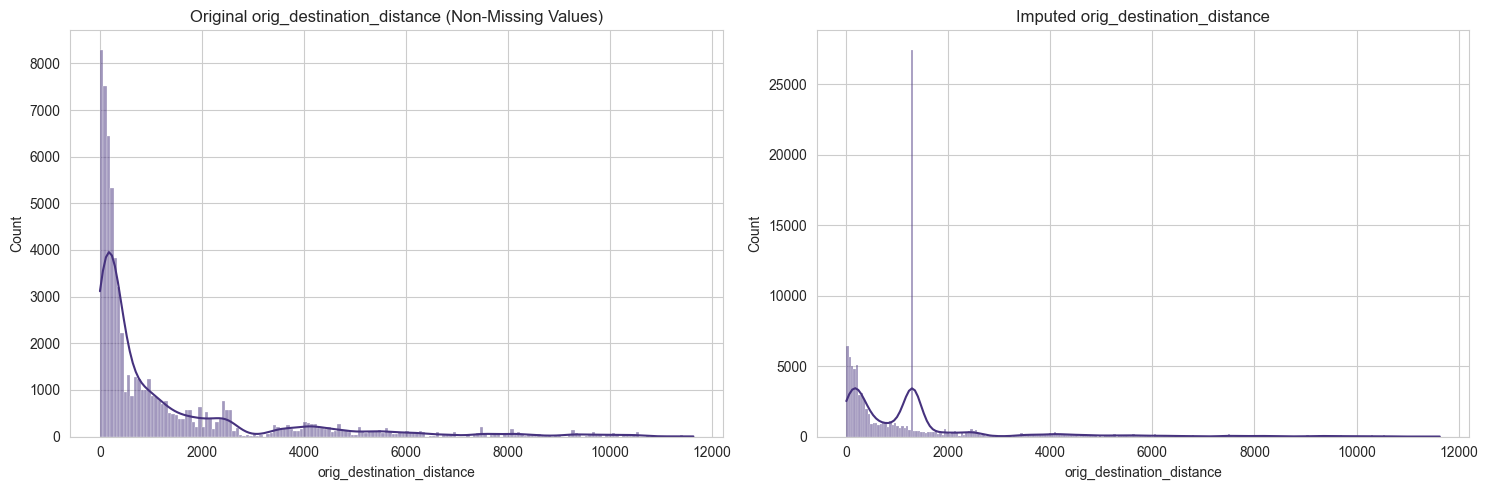

       Original (Non-Missing)   Imputed
count                67908.00 100000.00
mean                  1310.84   1298.55
std                   2025.86   1718.59
min                      0.01      0.01
25%                    145.44    213.72
50%                    382.49   1020.68
75%                   1504.08   1298.55
max                  11631.95  11631.95

Comparing distributions for prop_location_score2


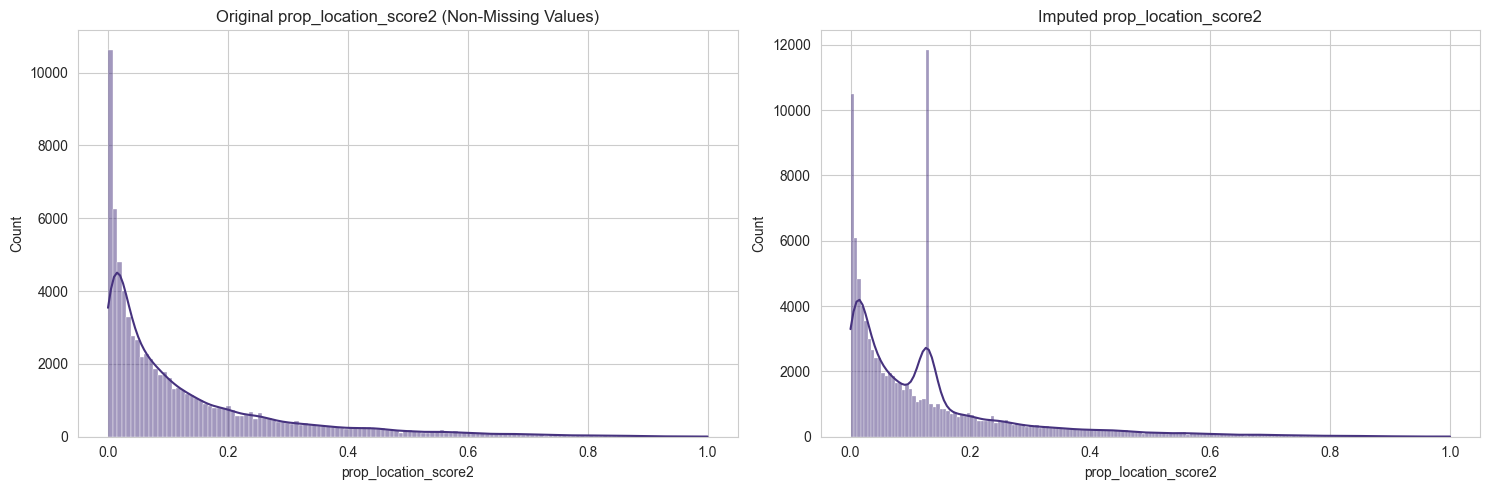

       Original (Non-Missing)   Imputed
count                78272.00 100000.00
mean                     0.13      0.13
std                      0.16      0.15
min                      0.00      0.00
25%                      0.02      0.02
50%                      0.07      0.08
75%                      0.18      0.16
max                      1.00      1.00

Comparing distributions for prop_review_score


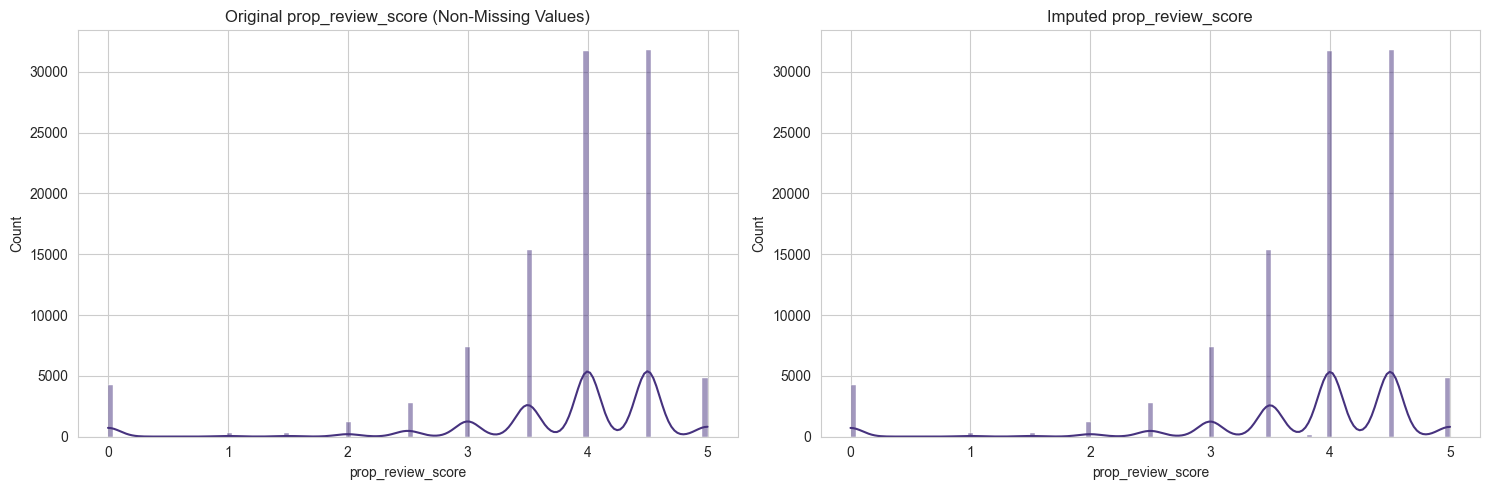

       Original (Non-Missing)   Imputed
count                99859.00 100000.00
mean                     3.81      3.81
std                      1.02      1.02
min                      0.00      0.00
25%                      3.50      3.50
50%                      4.00      4.00
75%                      4.50      4.50
max                      5.00      5.00


In [47]:
# Compare distributions for key imputed features
for col in imputable_cols:
    if col in numeric_features and df_sample[col].isnull().sum() > 0:
        print(f"\nComparing distributions for {col}")
        
        plt.figure(figsize=(15, 5))
        
        # Original non-missing data
        plt.subplot(1, 2, 1)
        sns.histplot(df_sample[col].dropna(), kde=True)
        plt.title(f'Original {col} (Non-Missing Values)')
        
        # Imputed data
        plt.subplot(1, 2, 2)
        sns.histplot(df_imputed[col], kde=True)
        plt.title(f'Imputed {col}')
        
        plt.tight_layout()
        plt.show()
        
        # Compare statistics
        stats_comparison = pd.DataFrame({
            'Original (Non-Missing)': df_sample[col].dropna().describe(),
            'Imputed': df_imputed[col].describe()
        })
        print(stats_comparison)

## Saving the Imputed Dataset


In [48]:
# Save the sample imputed dataset to a CSV file
df_imputed.to_csv('imputed_sample_data.csv', index=False)
print(f"Imputed sample dataset saved to 'imputed_sample_data.csv'")

Imputed sample dataset saved to 'imputed_sample_data.csv'


## Function for Imputing the Full Dataset



In [50]:
def impute_expedia_dataset(input_path, output_path, batch_size=100000):
    """
    Impute missing values in the Expedia dataset, processing in batches to handle large data.
    
    Parameters:
    -----------
    input_path : str
        Path to the input CSV file
    output_path : str
        Path to save the imputed CSV file
    batch_size : int
        Number of rows to process in each batch
    """
    # Read the first batch to get column types and build imputers
    print(f"Loading first batch of {batch_size} rows to build imputers...")
    first_batch = pd.read_csv(input_path, nrows=batch_size)
    
    # Analyze missing values
    missing_data = (first_batch.isnull().sum() / len(first_batch) * 100).round(2)
    imputable_cols = missing_data[(missing_data > 0) & (missing_data < 50)].index.tolist()
    print(f"Found {len(imputable_cols)} columns with less than 50% missing values")
    
    # Initialize counters
    total_rows_processed = 0
    batch_num = 0
    
    # Process the dataset in batches
    for df_batch in pd.read_csv(input_path, chunksize=batch_size):
        batch_num += 1
        start_time = time.time()
        print(f"Processing batch {batch_num}, rows {total_rows_processed + 1} to {total_rows_processed + len(df_batch)}")
        
        # Apply imputation strategies to this batch
        df_imputed = df_batch.copy()
        
        # User history features
        user_history_cols = [col for col in ['visitor_hist_starrating', 'visitor_hist_adr_usd'] if col in imputable_cols]
        for col in user_history_cols:
            df_imputed = group_based_imputation(df_imputed, 'visitor_location_country_id', col)
            # Fallback to mean if still missing
            if df_imputed[col].isnull().sum() > 0:
                df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())
        
        # Property features
        property_cols = [col for col in [
            'prop_starrating', 'prop_review_score', 'prop_brand_bool',
            'prop_location_score1', 'prop_location_score2'
        ] if col in imputable_cols]
        for col in property_cols:
            df_imputed = group_based_imputation(df_imputed, 'prop_id', col)
            # Fallback to median if still missing
            if df_imputed[col].isnull().sum() > 0:
                df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
        
        # Price features
        price_cols = [col for col in ['price_usd', 'prop_log_historical_price'] if col in imputable_cols]
        for col in price_cols:
            # Try by prop_id first
            df_imputed = group_based_imputation(df_imputed, 'prop_id', col)
            # Then try by star rating
            if df_imputed[col].isnull().sum() > 0:
                df_imputed = group_based_imputation(df_imputed, 'prop_starrating', col)
            # Fallback to median
            if df_imputed[col].isnull().sum() > 0:
                df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
        
        # Location features
        if 'orig_destination_distance' in imputable_cols:
            # Create a combined feature for grouping
            df_imputed['location_group'] = df_imputed['visitor_location_country_id'].astype(str) + "_" + \
                                           df_imputed['srch_destination_id'].astype(str)
            # Group by visitor country and destination
            df_imputed = group_based_imputation(df_imputed, 'location_group', 'orig_destination_distance')
            # Drop the temporary grouping column
            df_imputed = df_imputed.drop(columns=['location_group'])
            # Try by destination only if still missing
            if df_imputed['orig_destination_distance'].isnull().sum() > 0:
                df_imputed = group_based_imputation(df_imputed, 'srch_destination_id', 'orig_destination_distance')
            # Fallback to median
            if df_imputed['orig_destination_distance'].isnull().sum() > 0:
                df_imputed['orig_destination_distance'] = df_imputed['orig_destination_distance'].fillna(
                    df_imputed['orig_destination_distance'].median())
        
        # Competitor features
        comp_cols = [col for col in imputable_cols if col.startswith('comp')]
        for i in range(1, 9):  # 8 competitors
            comp_rate_col = f'comp{i}_rate'
            comp_inv_col = f'comp{i}_inv'
            comp_diff_col = f'comp{i}_rate_percent_diff'
            
            # Only process columns that are in our imputable list
            cols_to_process = [col for col in [comp_rate_col, comp_inv_col, comp_diff_col] if col in comp_cols]
            
            if not cols_to_process:
                continue
                
            # First, ensure consistency
            if comp_rate_col in cols_to_process:
                df_imputed[comp_rate_col] = df_imputed[comp_rate_col].fillna(0)
                
                if comp_inv_col in cols_to_process:
                    mask = (df_imputed[comp_rate_col] == 0) & (df_imputed[comp_inv_col].isnull())
                    df_imputed.loc[mask, comp_inv_col] = 0
            
            if comp_inv_col in cols_to_process and comp_rate_col not in cols_to_process:
                df_imputed[comp_inv_col] = df_imputed[comp_inv_col].fillna(0)
            
            if comp_diff_col in cols_to_process:
                if comp_rate_col in df_imputed.columns:
                    mask = (df_imputed[comp_rate_col] == 1) & (df_imputed[comp_diff_col].isnull())
                    if mask.sum() > 0:
                        temp_df = df_imputed[df_imputed[comp_rate_col] == 1]
                        if not temp_df.empty and temp_df[comp_diff_col].notnull().any():
                            # Group by star rating
                            temp_means = temp_df.groupby('prop_starrating')[comp_diff_col].mean()
                            # Apply to missing values where possible
                            for star in temp_means.index:
                                star_mask = mask & (df_imputed['prop_starrating'] == star)
                                df_imputed.loc[star_mask, comp_diff_col] = temp_means[star]
                            
                            # For any remaining, use overall mean
                            still_missing = (df_imputed[comp_rate_col] == 1) & (df_imputed[comp_diff_col].isnull())
                            if still_missing.sum() > 0 and temp_df[comp_diff_col].notnull().any():
                                df_imputed.loc[still_missing, comp_diff_col] = temp_df[comp_diff_col].mean()
        
        # Any remaining features with missing values
        remaining_cols = [col for col in imputable_cols if df_imputed[col].isnull().sum() > 0]
        for col in remaining_cols:
            # Skip columns that should remain partially null (like competitor diffs)
            if col.endswith('rate_percent_diff'):
                continue
                
            if df_batch[col].dtype in ['int64', 'float64']:
                df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
            else:
                # Use mode for categorical
                if not df_imputed[col].dropna().empty:
                    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode()[0])
        
        # Write to output file (append mode for all but first batch)
        if batch_num == 1:
            df_imputed.to_csv(output_path, index=False)
        else:
            df_imputed.to_csv(output_path, mode='a', header=False, index=False)
        
        # Update counters and report progress
        total_rows_processed += len(df_batch)
        elapsed_time = time.time() - start_time
        print(f"Batch {batch_num} completed in {elapsed_time:.2f} seconds. Total rows processed: {total_rows_processed:,}")
    
    print(f"Imputation complete! Imputed data saved to {output_path}")

# Full cdata imputation

In [51]:
# This will process the full dataset - this may take a long time and consume significant memory
# Uncomment to run

impute_expedia_dataset(
    input_path="../data/training_set_VU_DM.csv",
    output_path="../data/training_set_VU_DM_imputed.csv",
    batch_size=100000
)

Loading first batch of 100000 rows to build imputers...
Found 3 columns with less than 50% missing values
Processing batch 1, rows 1 to 100000
Batch 1 completed in 2.95 seconds. Total rows processed: 100,000
Processing batch 2, rows 100001 to 200000
Batch 2 completed in 2.63 seconds. Total rows processed: 200,000
Processing batch 3, rows 200001 to 300000
Batch 3 completed in 2.64 seconds. Total rows processed: 300,000
Processing batch 4, rows 300001 to 400000
Batch 4 completed in 2.62 seconds. Total rows processed: 400,000
Processing batch 5, rows 400001 to 500000
Batch 5 completed in 2.81 seconds. Total rows processed: 500,000
Processing batch 6, rows 500001 to 600000
Batch 6 completed in 2.80 seconds. Total rows processed: 600,000
Processing batch 7, rows 600001 to 700000
Batch 7 completed in 2.72 seconds. Total rows processed: 700,000
Processing batch 8, rows 700001 to 800000
Batch 8 completed in 2.81 seconds. Total rows processed: 800,000
Processing batch 9, rows 800001 to 900000
B